# Assignment 5: GANs - Kai Ponel & Hannan Mahadik 

# Imports

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
# import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, losses, optimizers, metrics
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten,Activation
import os

import matplotlib.pyplot as plt

2023-05-24 10:03:24.552949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 10:03:29.566985: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/scratch/ponel/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-05-24 10:03:29.567314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing import image
import pandas as pd

In [3]:
path_to_data = '/content/drive/MyDrive/ColabNotebooks/LGM_Hannan_Kai/Task 5/animals'

# Dataset

# MNIST


In [4]:
with np.load('/data/project/FoolingDetection/mnist.npz') as data:
    x_train, x_test = data['x_train'] / 255., data['x_test'] / 255.
    y_train, y_test = data['y_train'], data['y_test']

x_train, x_test = x_train.reshape(-1, 28, 28, 1), x_test.reshape(-1, 28, 28, 1)

batch_size = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

In [5]:
# ds = tf.keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = ds.load_data()

In [6]:
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_images).batch(BATCH_SIZE)

# Model

In [9]:
LATENT_DIM = 10

## Generator

In [10]:
class Generator(layers.Layer):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim
        self.dense1 = layers.Dense(7*7*256)
        self.bn1 = layers.BatchNormalization()
        self.lr1 = layers.LeakyReLU()

        self.reshape = layers.Reshape((7, 7, 256))

        self.convt1 = layers.Conv2DTranspose(128, 5, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.lr2 = layers.LeakyReLU()

        self.convt2 = layers.Conv2DTranspose(64, 5, strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.lr3 = layers.LeakyReLU()

        self.convt3 = layers.Conv2DTranspose(1, 5, strides=2, padding='same')

    @tf.function
    def call(self, noise):
        x = self.dense1(noise)
        x = self.bn1(x)
        x = self.lr1(x)
        x = self.reshape(x) 

        x = self.convt1(x)
        x = self.bn2(x)
        x = self.lr2(x)

        x = self.convt2(x)
        x = self.bn3(x)
        x = self.lr3(x)

        x = self.convt3(x)
        return x


In [11]:
generator = Generator(LATENT_DIM)

noise = tf.random.normal([1, 100])

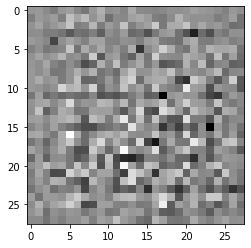

In [12]:
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

In [13]:
class Discriminator(layers.Layer):
    def __init__(self):
        super().__init__()

        self.conv1 = layers.Conv2D(64, 5, strides=2, padding='same')
        self.lr1 = layers.LeakyReLU()
        self.do1 = layers.Dropout(0.3)

        self.conv2 = layers.Conv2D(256, 5, strides=2, padding='same')
        self.lr2 = layers.LeakyReLU()
        self.do2 = layers.Dropout(0.3)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    @tf.function
    def call(self, input):
        x = self.conv1(input)
        x = self.lr1(x)
        x = self.do1(x)

        x = self.conv2(x)
        x = self.lr2(x)
        x = self.do2(x)

        x = self.flatten(x)
        x = self.dense(x)

        return x


In [14]:
discriminator = Discriminator()
decision = discriminator(generated_image)

## GAN

In [15]:
# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

In [16]:
# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
class DC_GAN(Model):
    def __init__(self, latent_dim, distribution, **kwargs):
        super().__init__(**kwargs)

        self.latent_dim = latent_dim
        self.distribution = distribution
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()

    def compile(self):
        super().compile()
    
        self.generator_optimizer = optimizers.Adam(1e-4)
        self.discriminator_optimizer = optimizers.Adam(1e-4)
    
        self.generator_loss = losses.BinaryCrossentropy(from_logits=True) 
        self.discriminator_loss = losses.BinaryCrossentropy(from_logits=True) 

        self.generator_loss_metric = metrics.Mean()
        self.discriminator_loss_metric = metrics.Mean()

    @property
    def metrics(self):
        return [self.generator_loss_metric, self.discriminator_loss_metric]

    @tf.function
    def train_step(self, input):
        batch_size = tf.shape(input)[0]

        # Train Discriminator    
        start = tf.random.normal([batch_size, self.latent_dim])
        generated_batch = self.generator(start)

        real_labels = tf.ones((batch_size, 1))
        generated_labels = tf.zeros((batch_size, 1))

        full_batch = tf.concat([input, generated_batch], axis=0)
        full_labels = tf.concat([real_labels, generated_labels], axis=0)

        with tf.GradientTape() as disc_tape:
            preds = self.discriminator(full_batch, training=True)
            disc_loss = self.discriminator_loss(full_labels, preds)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as gen_tape:
            start = tf.random.normal([batch_size, self.latent_dim])
            generated_batch = self.generator(start, training=True)
            d_output = self.discriminator(generated_batch)
            gen_loss = self.generator_loss(real_labels, d_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        self.generator_loss_metric.update_state(gen_loss)
        self.discriminator_loss_metric.update_state(disc_loss)

        return {
            "Discriminator Loss": self.discriminator_loss_metric.result(),
            "Generator Loss": self.generator_loss_metric.result(),
        }


In [18]:
distribution = tfp.distributions.Normal(0,1)
DCGAN = DC_GAN(LATENT_DIM, distribution)
DCGAN.compile()

In [19]:
import os
epoch = -1
save_dir = '/home/ponel/lgm5'

class ImShowCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        global epoch
        if batch == 100:
            epoch = epoch + 1
            if epoch % 100 == 0:
                noise = self.model.distribution.sample((5, self.model.LATENT_DIM))
                gens = self.model.generator(noise)

                plt.figure(figsize=(15, 3))
                for i, img in enumerate(gens):
                    plt.subplot(1, 5, i + 1)
                    plt.imshow(img)
                    plt.axis("off")
                plt.suptitle("epoch: " + str(epoch))

                # Save plot to local disk
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                filename = f'epoch_{epoch}.png'
                filepath = os.path.join(save_dir, filename)
                plt.savefig(filepath)

                # Display plot
                plt.show()

In [20]:
DCGAN.fit(train_dataset, epochs=25000, callbacks = [ImShowCallback()])

Epoch 1/25000


2023-05-24 10:03:52.604921: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/discriminator_1/StatefulPartitionedCall/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 93/235 [==========>...................] - ETA: 4s - Discriminator Loss: 0.5350 - Generator Loss: 0.6880

KeyboardInterrupt: 

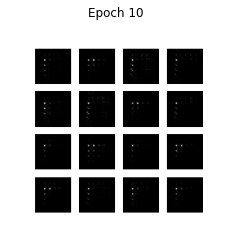

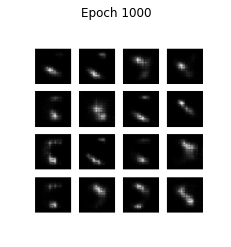

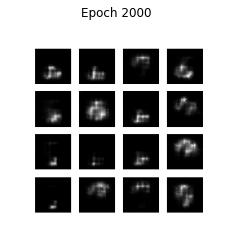

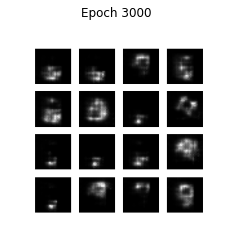

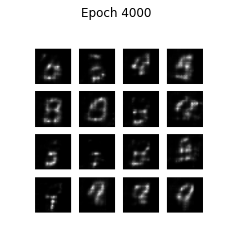

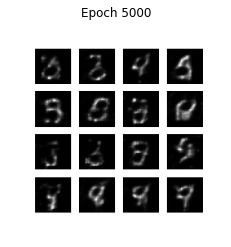

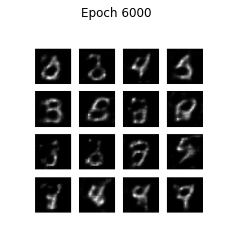

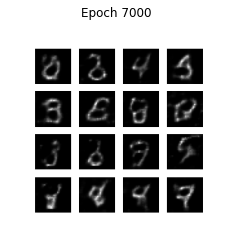

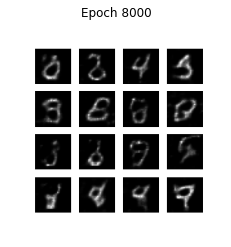

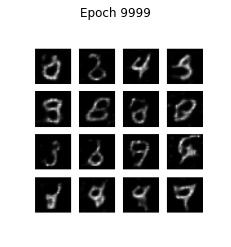

In [24]:
### Print Results which had been stored on disk due to longer training.

import matplotlib.image as mpimg

filepath = "/home/ponel/lgmt5"

epochs = [10] + list(range(1000, 10000, 1000))
epochs[-1] = 9999  # replace the last element with 9999

# iterate through the epochs, load the corresponding image, and display it
for epoch in epochs:
    img_path = os.path.join(filepath, f"epoch_{epoch}.png")
    img = mpimg.imread(img_path)
    
    plt.figure()
    plt.title(f"Epoch {epoch}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()